In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install mne

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 15.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('./drive/MyDrive/Sidorov_Diploma/p300_detection/pattern_recognition')

[autoreload of psutil._pslinux failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.8/dist-packages/psutil/_pslinux.py", line 87, in <module>
    PAGESIZE = cext_posix.getpagesize()
AttributeError: module 'psutil_posix' has no attribute 'getpagesize'
]
[autoreload of psutil failed: Trace

Mounted at /content/drive/


In [2]:
from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models import * 
from graph import get_delaunay_graph

ModuleNotFoundError: No module named 'data'

In [3]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph, get_neighbors_graph

In [4]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [5]:
#DATA_PATH = '/content/drive/MyDrive/Sidorov_Diploma/p300_detection/BCI_Comp_III_Wads_2004/'
DATA_PATH = '../matrix_dataset/'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Train.mat')
train_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Test.mat')
test_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

In [6]:
train_A_chars = list(train_A_raw['TargetChar'][0])
train_B_chars = list(train_B_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')
test_B_chars = list('MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR')

In [7]:
A_train_ds = P300Getter(train_A_raw, eloc)
A_test_ds = P300Getter(test_A_raw, eloc, target_chars=test_A_chars)

A_train_ds.get_cnn_p300_dataset(filter=True)
A_test_ds.get_cnn_p300_dataset(filter=True)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.79it/s]


In [8]:
B_train_ds = P300Getter(train_B_raw, eloc)
B_test_ds = P300Getter(test_B_raw, eloc, target_chars=test_B_chars)

B_train_ds.get_cnn_p300_dataset(filter=True)
B_test_ds.get_cnn_p300_dataset(filter=True)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.98it/s]


In [9]:
X_train_B, y_train_B = B_train_ds.get_data()
X_test_B, y_test_B = B_test_ds.get_data()

In [10]:
train_B_dataset = CNNMatrixDataset(tensors=(X_train_B, y_train_B), with_target=True, transform=None)
test_B_dataset = CNNMatrixDataset(tensors=(X_test_B, y_test_B), with_target=True, transform=None)

batch_size = 180 #256

train_B_CNN = DataLoader(train_B_dataset, batch_size=batch_size) # , shuffle=True
test_B_CNN = DataLoader(test_B_dataset, batch_size=batch_size) # , shuffle=True

data_loaders_CNN_B = {'train':train_B_CNN, 'val':test_B_CNN}

In [11]:
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=120)

In [12]:
#A_train_ds.upsample(2)
#A_test_ds.upsample(2)

In [13]:
X_train_A, y_train_A = A_train_ds.get_data()
X_test_A, y_test_A = A_test_ds.get_data()

In [14]:
train_A_dataset = CNNMatrixDataset(tensors=(X_train_A, y_train_A), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(X_test_A, y_test_A), with_target=True, transform=None)

batch_size = 180 #256

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size) # , shuffle=True
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size) # , shuffle=True

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [ ]:
graph = get_delaunay_graph(eloc)
Del_A_train_data = GraphMatrixDataset("MYdata", train_A_raw, graph, DATA_PATH, eloc, label='train')
Del_A_test_data = GraphMatrixDataset("MYdata", test_A_raw, graph, DATA_PATH, eloc, test_chars=test_A_chars, label='test')

In [ ]:
from torch_geometric.loader import DataLoader as GraphLoader

batch_size = 180 #256

train_A_GNN = GraphLoader(Del_A_train_data, batch_size=batch_size) # , shuffle=True
test_A_GNN = GraphLoader(Del_A_test_data, batch_size=batch_size) # , shuffle=True

data_loaders_GNN = {'train':train_A_GNN, 'val':test_A_GNN}

In [15]:
learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-3,
    'weight_decay' : 0,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'GNN'
  }

In [ ]:
num_epochs = 100
lr = 1e-3
weight_decay = 1e-1
step_size = 5
gamma = 1

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

criterion = nn.BCEWithLogitsLoss() # pos_weight=torch.tensor([1, 5], device=my_device)
model_GNN = GCNModel(72, num_layers=1, classifier_width_ratio=4)

loss, acc, total_time = train_GCN_model(model_GNN, data_loaders_GNN, criterion, num_epochs=num_epochs, device=my_device)

In [ ]:
class base_GNN_big(nn.Module):
    def __init__(self, input_feat_dim, n_channels, adj, time_kernel=13, num_classes=2, channel_filters=1):
        super(base_GNN_big, self).__init__()

        self.num_classes = num_classes

        self.gc1 = base_GIN(input_feat_dim, input_feat_dim, adj)
        self.gc2 = base_GIN(input_feat_dim, input_feat_dim, adj)

        self.linear_channel = nn.Conv1d(n_channels, channel_filters, kernel_size=1, bias=True)
        
        self.conv = nn.Conv1d(channel_filters, 1, kernel_size=time_kernel, padding='same')
        self.bn1 = nn.BatchNorm1d(1)
        self.hook = nn.ReLU(True)
        self.linear_output = nn.Linear(input_feat_dim, num_classes, bias=True)

    def forward(self, x):
        x = self.gc1(x)
        x = self.gc2(x)
        x = self.linear_channel(x)
        x = self.conv(x)
        x = self.bn1(x)
        x = torch.flatten(x, 1)
        x = self.hook(x)
        x = self.linear_output(x)
        
        return x

In [ ]:
B = torch.bernoulli(torch.zeros(64, 64) + 0.5)
i, j = torch.triu_indices(64, 64)
B[i, j] = B.T[i, j]
k = torch.arange(64)
B[k, k] = 0

In [ ]:
criterion = nn.BCEWithLogitsLoss() #nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3)) weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-3,
    'weight_decay' : 0,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
#B = B.to(my_device)
model_CNN = base_GNN_big(72, 64, A)

loss, acc, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, device=my_device)

cuda:0
Epoch 9/99
----------
train Loss: 0.4378 Acc: 0.8333 Ones: 0.0000
val Loss: 0.4466 Acc: 0.8333 Ones: 0.0000
Epoch 19/99
----------
train Loss: 0.4216 Acc: 0.8345 Ones: 0.8471
val Loss: 0.4305 Acc: 0.8331 Ones: 0.2600
Epoch 29/99
----------
train Loss: 0.4170 Acc: 0.8348 Ones: 1.1412
val Loss: 0.4317 Acc: 0.8334 Ones: 0.4300
Epoch 39/99
----------
train Loss: 0.4149 Acc: 0.8349 Ones: 1.4118
val Loss: 0.4323 Acc: 0.8328 Ones: 0.5300
Epoch 49/99
----------
train Loss: 0.4187 Acc: 0.8344 Ones: 1.2118
val Loss: 0.4330 Acc: 0.8331 Ones: 0.4900
Epoch 59/99
----------
train Loss: 0.4082 Acc: 0.8354 Ones: 1.9765
val Loss: 0.4354 Acc: 0.8328 Ones: 0.8400
Epoch 69/99
----------
train Loss: 0.4044 Acc: 0.8359 Ones: 2.2000
val Loss: 0.4374 Acc: 0.8325 Ones: 1.0700
Epoch 79/99
----------
train Loss: 0.4000 Acc: 0.8375 Ones: 2.7647
val Loss: 0.4394 Acc: 0.8316 Ones: 1.7400
Epoch 89/99
----------
train Loss: 0.3967 Acc: 0.8373 Ones: 3.0471
val Loss: 0.4425 Acc: 0.8314 Ones: 1.6500
Epoch 99/99
-

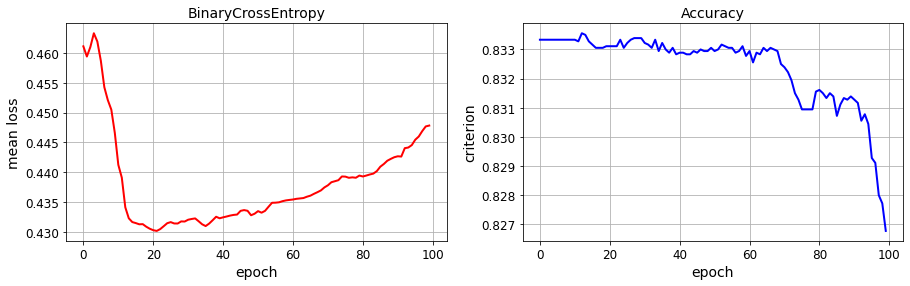

In [ ]:
show_progress(loss, acc, 'BinaryCrossEntropy', 'Accuracy')

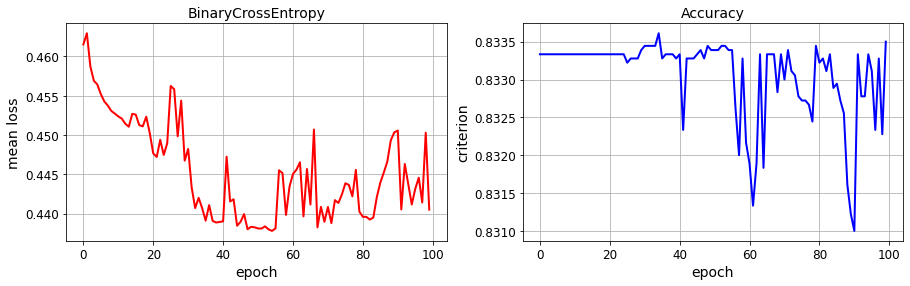

In [ ]:
show_progress(loss, acc, 'BinaryCrossEntropy', 'Accuracy')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-62-0c266b42eae3>:3: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)


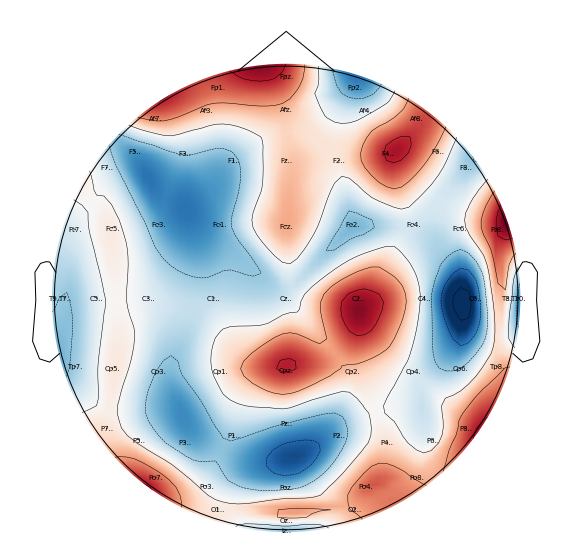

In [ ]:
channel_weights = np.array(model_CNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [ ]:
model_CNN.gc.h.weight.size()

torch.Size([72, 72])

In [16]:
def get_autoregressive_mask(size):
    """
    Returns attention mask of given size for autoregressive model.
    """
    dtype = getattr(torch, 'bool', None) or torch.uint8
    res = torch.zeros(size, size, dtype=dtype)
    for i in range(size - 1):
        res[i, i + 1:] = 1
    return res

In [17]:
class PositionalEncoder(nn.Module):
    def __init__(self, dim, max_len=50, scale=10000.0, add=True):
        """
        Transforms input as described by Vaswani et al. in "Attention Is All You Need", 2017.
        dim     - dimension of positional embeddings.
        max_len - maximal length of sequence, for precomputing
        scale   - scale factor for frequency for positional embeddings
        add     - boolean, if add is False, concatenate positional embeddings with input instead of adding
        """
        super().__init__()
        
        self.dim = dim
        self.add = add
        self.max_len = max_len
        
        self.pe = torch.zeros(1, max_len, dim)
        arg = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) /\
             torch.pow(scale, torch.arange(0, dim, 2, dtype=torch.float32) / dim)
        self.pe[:, :, 0::2] = torch.sin(arg)
        self.pe[:, :, 1::2] = torch.cos(arg)
               
    def forward(self, input):
        """
        input - [batch_size x sequence_len x features_dim]
        If self.add is True, self.dim = featurs_dim.
        Returns input with added or concatenated positional embeddings (depending on self.add).
        """
        if self.add:
            result = input + self.pe[:, :input.size(1), :].to(input.device)
        else:
            result = torch.cat([input, self.pe.repeat(input.size(0), 1, 1)[:, :input.size(1), :].to(input.device)], dim=2)
        return result

In [18]:
class base_CNN_attn(nn.Module):
    def __init__(self, input_feat_dim, n_channels=64, num_classes=2):
        super(base_CNN_attn, self).__init__()

        self.num_classes = num_classes
        num_filters = 1
        embedding_dim = 128
        self.mask = get_autoregressive_mask(input_feat_dim)

        self.linear_channel = nn.Conv1d(n_channels, num_filters, kernel_size=1, bias=True)

        #self.embeds = nn.Embedding(input_feat_dim, embedding_dim)
        self.pos_enc = PositionalEncoder(num_filters, input_feat_dim, 100, True)
        self.queries = nn.Linear(input_feat_dim, input_feat_dim)
        #self.dp = nn.Dropout(p=0.5, inplace=False)

        self.attn = nn.MultiheadAttention(num_filters, 1, dropout=0.0, batch_first=True)
        self.hook = nn.ReLU(True)
        self.linear_output = nn.Linear(input_feat_dim * num_filters, num_classes, bias=True)

    def forward(self, x):
        x = self.linear_channel(x)
        
        #x = self.embeds(x)
        x = self.pos_enc(x)
        #x = self.dp(x)
        #queries = self.queries(x)
        #x = self.attention(queries, x, x, get_autoregressive_mask(x.size(1)))

        x = x.transpose(1, 2)
        #queries = queries.transpose(1, 2)
        x, self.attn_weights = self.attn(x, x, x, attn_mask=self.mask.to(x.device)) # , average_attn_weights=True

        x = torch.flatten(x, 1)
        x = self.hook(x)
        x = self.linear_output(x)
        
        return x

In [ ]:
model_CNN.queries.weight.size()

torch.Size([72, 72])

In [ ]:
import seaborn as sns

In [ ]:
model_CNN.attn_weights.detach().cpu().sum(0)

tensor([ 1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2., 24.,  0.,  1., 10.,
         1.,  0.,  0.,  1.,  0.,  0.,  7.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  5.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1., 26.,  6.,  0., 24.,  8., 13.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  3.,  0.,  2., 14.,  2.,  1.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

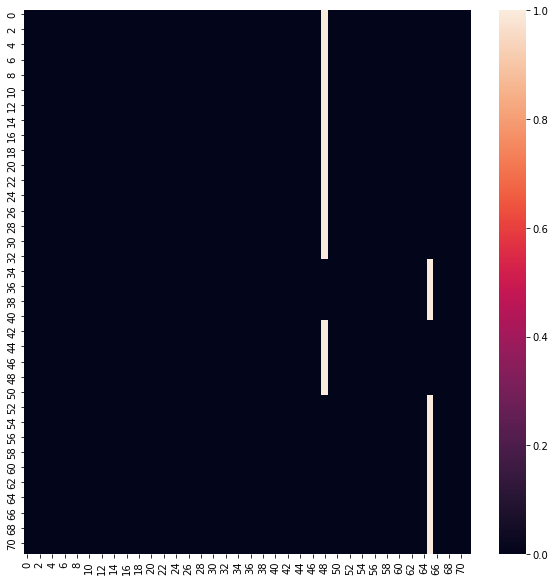

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(model_CNN.attn_weights.detach().cpu()[30])
plt.show()

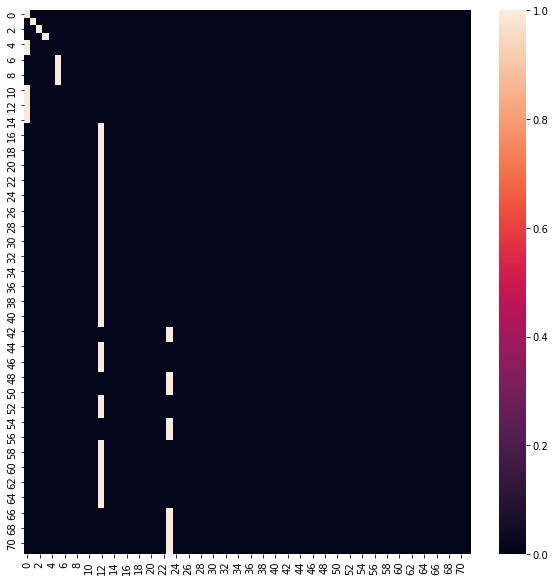

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(model_CNN.attn_weights.detach().cpu()[30])
plt.show()

In [20]:
criterion = nn.BCEWithLogitsLoss() #nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3)) weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-3,
    'weight_decay' : 0,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

model_CNN = base_CNN_attn(48, n_channels=64)
#model_CNN = EEGNet()

loss, acc, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, device=my_device)

cuda:0
Training complete in 1m 59s


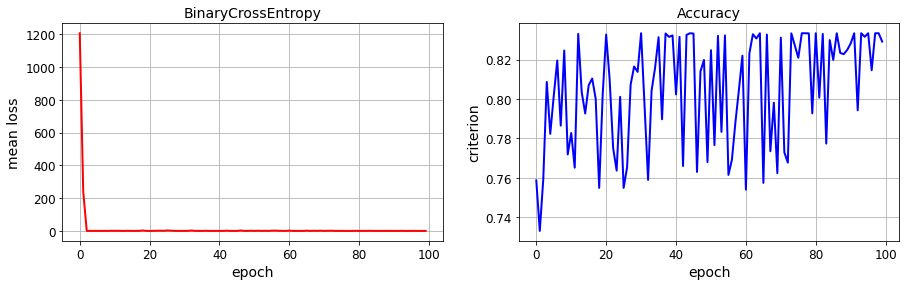

In [ ]:
show_progress(loss, acc, 'BinaryCrossEntropy', 'Accuracy')

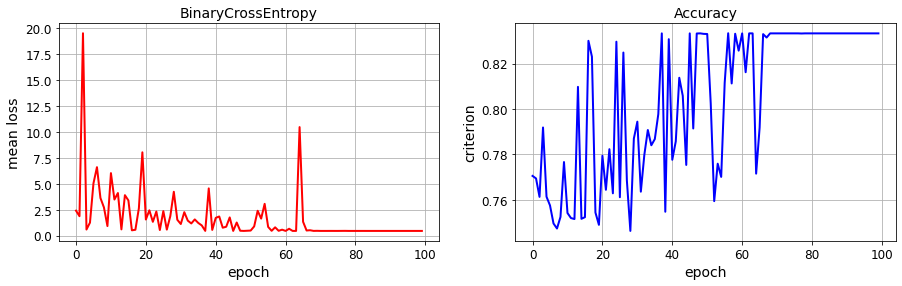

In [ ]:
show_progress(loss, acc, 'BinaryCrossEntropy', 'Accuracy')

In [ ]:
model_CNN = base_CNN(72, n_channels=64)

In [ ]:
sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)

227

In [ ]:
sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)

918

In [ ]:
sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)

5475

In [ ]:
channel_weights = np.array(model_CNN.linear_channel.weight.flatten().detach().cpu())

In [ ]:
test_A_dataset[5779][0].unsqueeze(0)

tensor([[[ -1142611.5000,   5167985.5000,  12374393.0000,  ...,
           -1043724.7500,   -886111.7500,  -2126670.5000],
         [  1596761.6250,   4999451.5000,  10383252.0000,  ...,
           -3377985.7500,  -3949550.2500,  -6435891.0000],
         [  1283117.3750,   2737508.2500,   6215602.0000,  ...,
           -8279639.5000,  -8433825.0000,  -9181424.0000],
         ...,
         [  2805959.2500,   4028281.0000,   4300472.5000,  ...,
          -14493578.0000, -14097458.0000, -14249191.0000],
         [ -6354003.0000,  -7177533.0000,  -6267937.5000,  ...,
           -4992923.5000,  -4588820.5000,  -5499380.0000],
         [  3181705.2500,   4395854.0000,   4633416.0000,  ...,
           -6373649.5000,  -6208496.0000,  -7463387.5000]]])

In [ ]:
test_A_dataset[17609][0].unsqueeze(0).size()

torch.Size([1, 64, 72])

In [ ]:
test_A_dataset[17609][0].unsqueeze(0)

tensor([[[ -2734932.2500,  -2205401.5000,  -2384375.5000,  ...,
          -12167321.0000,  -6452726.0000,  -1612852.6250],
         [ -4023507.7500,  -2055314.6250,  -2218650.0000,  ...,
          -10417834.0000,  -5031255.0000,    679749.0625],
         [  -403432.3750,   2858506.7500,   3697501.5000,  ...,
           -8190336.5000,  -3571952.7500,   2275162.5000],
         ...,
         [  8135786.0000,   8126768.0000,   6778000.0000,  ...,
           -6863748.5000,  -6677267.0000,  -6057907.0000],
         [   687650.0625,   1766414.0000,    966359.1250,  ...,
           -5176970.5000,  -6290604.5000,  -6743357.5000],
         [   696962.5000,    495416.5625,    226424.7812,  ...,
           -3280385.0000,  -3528444.2500,  -3094838.7500]]])

In [ ]:
output.shape[1]

72

In [ ]:
t = np.where(np.array(train_A_dataset[:][1][:,1]))[0]

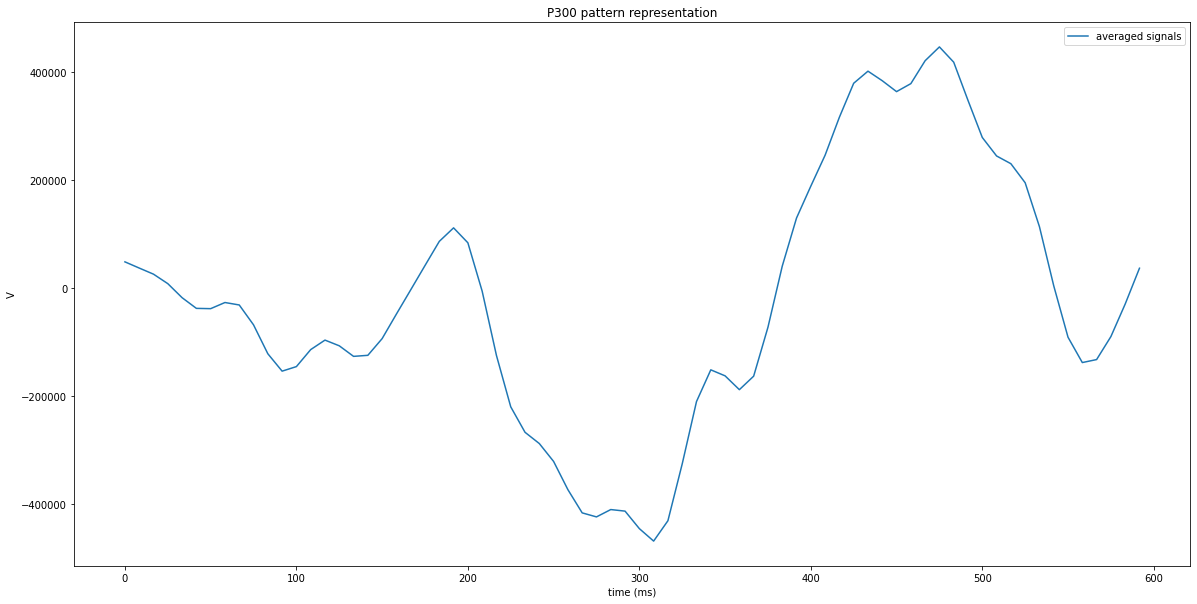

In [ ]:
plt.figure(figsize=(10, 10))
t = np.where(np.array(train_A_dataset[:][1][:,1]))[0]
res = train_A_dataset[t][0].mean(0).mean(0)
plt.plot(t_axis, res, label='averaged signals')

plt.ylabel('V')
plt.legend()
plt.xlabel('time (ms)')
plt.title('P300 pattern representation')
plt.show()

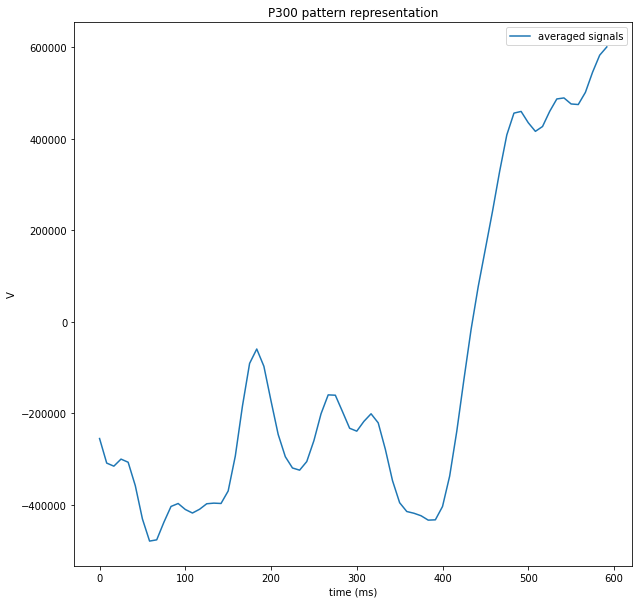

In [ ]:
plt.figure(figsize=(10, 10))
t = np.where(np.array(train_B_dataset[:][1][:,1]))[0]
res = train_B_dataset[t][0].mean(0).mean(0)
plt.plot(t_axis, res, label='averaged signals')

plt.ylabel('V')
plt.legend()
plt.xlabel('time (ms)')
plt.title('P300 pattern representation')
plt.show()

In [ ]:
np.where(np.array(test_A_dataset[:][1][:,1]))[0][-20:]

array([17882, 17891, 17896, 17900, 17905, 17910, 17916, 17926, 17929,
       17931, 17946, 17949, 17952, 17959, 17964, 17969, 17976, 17979,
       17996, 17997])

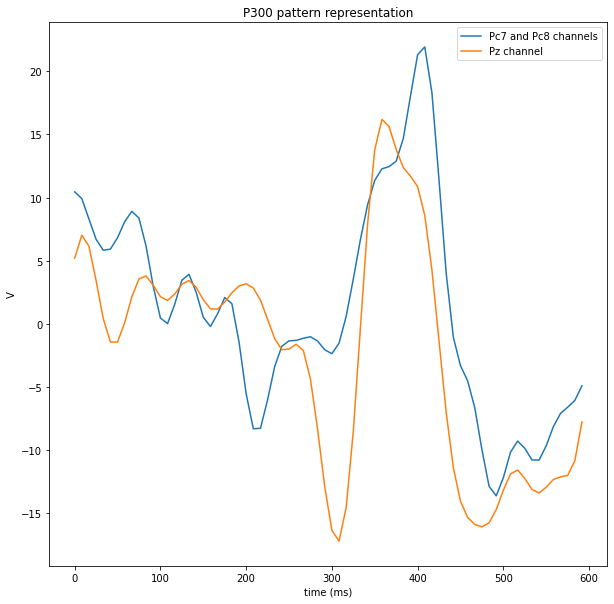

In [ ]:
signal_sample = test_A_dataset[17609][0].unsqueeze(0) # 17609
x = model_CNN.linear_channel(signal_sample.to(my_device))
signal = torch.flatten(x).detach().cpu()
x = x.transpose(1, 2)
_, attn_weights = model_CNN.attn(x, x, x)
matrix = attn_weights[0].detach().cpu()

plt.figure(figsize=(10, 10))
t_axis = np.arange(72) / info['sfreq'] * 1000
#plt.plot(t_axis, signal, label='weighted signal')
temp_matrix = matrix.sum(0)
temp_matrix /= temp_matrix.sum()

output = A_test_ds.unscale(signal_sample.numpy())[0]
plt.plot(t_axis, (output[55] + output[59]) / 2, label='Pc7 and Pc8 channels')
plt.plot(t_axis, output[50], label='Pz channel')

#for i in range(0, 72):
#    if temp_matrix[i] == 0:
#        plt.axvline(t_axis[i], c='r', alpha=0.2, linewidth=7)
#    else:
#        plt.axvline(t_axis[i], c='g', alpha=float(temp_matrix[i]), linewidth=10)
#        plt.axvline(t_axis[i], c='b', alpha=0.5)
  
plt.ylabel('V')
plt.legend()
plt.xlabel('time (ms)')
plt.title('P300 pattern representation')
plt.show()

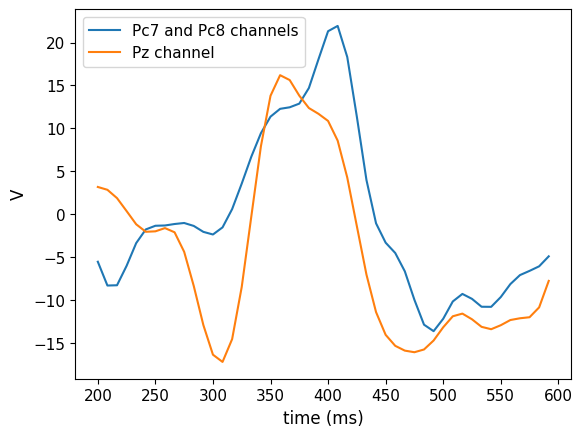

In [58]:
signal_sample = test_A_dataset[17609][0].unsqueeze(0) # 17609
x = model_CNN.linear_channel(signal_sample.to(my_device))
signal = torch.flatten(x).detach().cpu()
x = x.transpose(1, 2)
_, attn_weights = model_CNN.attn(x, x, x)
matrix = attn_weights[0].detach().cpu()

#plt.figure(figsize=(10, 10))
t_axis = np.arange(48) / info['sfreq'] * 1000 + 200
#plt.plot(t_axis, signal, label='weighted signal')
temp_matrix = matrix.sum(0)
temp_matrix /= temp_matrix.sum()

output = A_test_ds.unscale(signal_sample.numpy())[0]
plt.plot(t_axis, (output[55] + output[59]) / 2, label='Pc7 and Pc8 channels')
plt.plot(t_axis, output[50], label='Pz channel')

#for i in range(0, 72):
#    if temp_matrix[i] == 0:
#        plt.axvline(t_axis[i], c='r', alpha=0.2, linewidth=7)
#    else:
#        plt.axvline(t_axis[i], c='g', alpha=float(temp_matrix[i]), linewidth=10)
#        plt.axvline(t_axis[i], c='b', alpha=0.5)
  
plt.ylabel('V', fontsize=12)
plt.legend(fontsize=11)
plt.xlabel('time (ms)', fontsize=12)
#plt.title('P300 pattern representation')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('channels.png', pad_inches=0, dpi=300)
plt.show()

In [ ]:
signal_sample = test_A_dataset[17609][0].unsqueeze(0)
x = model_CNN.linear_channel(signal_sample.to(my_device))
signal = torch.flatten(x).detach().cpu()
x = x.transpose(1, 2)
_, attn_weights = model_CNN.attn(x, x, x)
matrix = attn_weights[0].detach().cpu()

plt.figure(figsize=(10, 10))
t_axis = np.arange(72) / info['sfreq'] * 1000
#plt.plot(t_axis, signal, label='weighted signal')
temp_matrix = matrix.sum(0)
temp_matrix /= temp_matrix.sum()

output = A_test_ds.unscale(signal_sample.numpy())[0]
plt.plot(t_axis, (output[55] + output[59]) / 2, label='Pc7 and Pc8 channels')
plt.plot(t_axis, output[50], label='Pz channel')

for i in range(0, 72):
    if temp_matrix[i] == 0:
        plt.axvline(t_axis[i], c='r', alpha=0.2, linewidth=7)
    else:
        plt.axvline(t_axis[i], c='g', alpha=float(temp_matrix[i]), linewidth=10)
        plt.axvline(t_axis[i], c='b', alpha=0.5)
  
plt.ylabel('V')
plt.legend()
plt.xlabel('time (ms)')
plt.title('P300 pattern representation')
plt.show()

In [ ]:
test_A_dataset[17609][0].size()

torch.Size([64, 72])

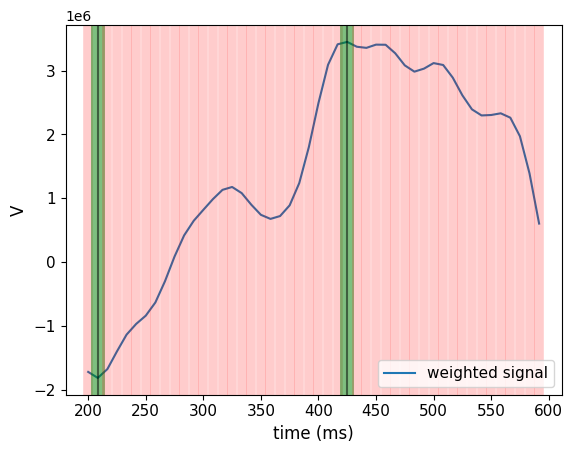

In [57]:
x = model_CNN.linear_channel(test_A_dataset[17609][0].unsqueeze(0).to(my_device))
signal = torch.flatten(x).detach().cpu()
x = x.transpose(1, 2)
_, attn_weights = model_CNN.attn(x, x, x)
matrix = attn_weights[0].detach().cpu()

#plt.figure(figsize=(10, 10))
t_axis = np.arange(48) / info['sfreq'] * 1000  + 200
plt.plot(t_axis, signal, label='weighted signal')
temp_matrix = matrix.sum(0)
temp_matrix /= temp_matrix.sum()

for i in range(0, 48):
    if temp_matrix[i] == 0:
        plt.axvline(t_axis[i], c='r', alpha=0.2, linewidth=6.9)
    else:
        plt.axvline(t_axis[i], c='g', alpha=0.5, linewidth=10) # float(temp_matrix[i])
        plt.axvline(t_axis[i], c='black', alpha=0.5)

plt.ylabel('V', fontsize=12)
plt.legend(fontsize=11)
plt.xlabel('time (ms)', fontsize=12)
#plt.title('P300 pattern representation')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('attention.png', pad_inches=0, dpi=300)
plt.show()

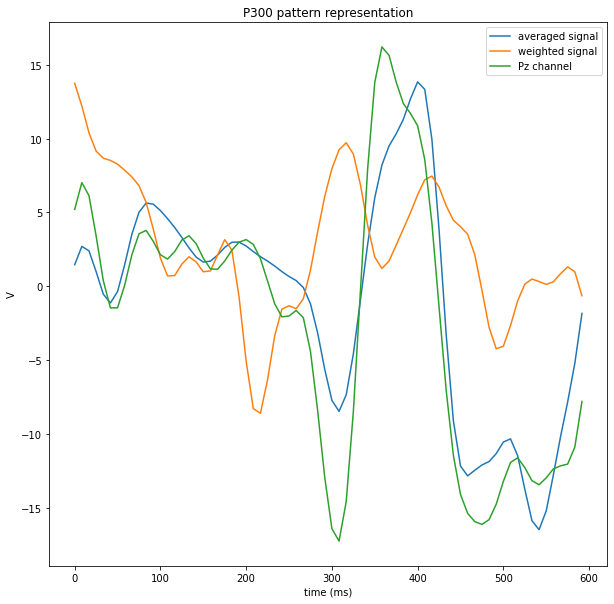

In [ ]:
signal_sample = test_A_dataset[17609][0].unsqueeze(0) # 17609 

output = A_test_ds.unscale(signal_sample.numpy())[0]

plt.figure(figsize=(10, 10))
mean_output = output.mean(axis=0)
t_axis = np.arange(len(mean_output)) / info['sfreq'] * 1000
plt.plot(t_axis, output.mean(axis=0), label='averaged signal')
plt.plot(t_axis, -1 * channel_weights @ output, label='weighted signal')
plt.plot(t_axis, output[50], label='Pz channel')
plt.ylabel('V')
plt.legend()
plt.xlabel('time (ms)')
plt.title('P300 pattern representation')
plt.show()

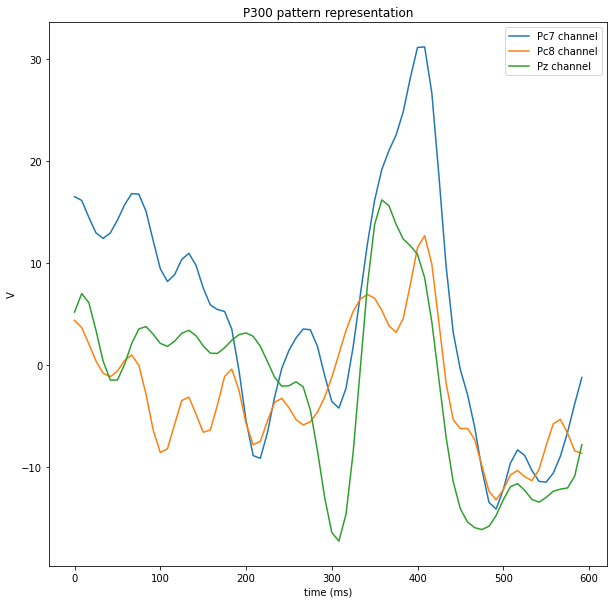

In [ ]:
signal_sample = test_A_dataset[17609][0].unsqueeze(0) # 17609 

output = A_test_ds.unscale(signal_sample.numpy())[0]

plt.figure(figsize=(10, 10))
mean_output = output.mean(axis=0)
t_axis = np.arange(len(mean_output)) / info['sfreq'] * 1000
plt.plot(t_axis, output[55], label='Pc7 channel')
plt.plot(t_axis, output[59], label='Pc8 channel')
plt.plot(t_axis, output[50], label='Pz channel')
plt.ylabel('V')
plt.legend() 
plt.xlabel('time (ms)')
plt.title('P300 pattern representation')
plt.show()

In [ ]:
channel_weights#.shape

(64,)

In [ ]:
channel_weights @ output

array([-0.03178969, -0.03491363, -0.01773813,  0.03956061,  0.1174984 ,
        0.16720226,  0.14880741,  0.06588273, -0.03564109, -0.10410558,
       -0.12174533, -0.1115033 , -0.10821179, -0.12458604, -0.14504666,
       -0.14825636, -0.1307293 , -0.10593484, -0.08475756, -0.0637583 ,
       -0.03563817, -0.00610999,  0.00723845, -0.00375101, -0.02202889,
       -0.0160301 ,  0.03197681,  0.10988823,  0.18677317,  0.23586528,
        0.24497038,  0.21100293,  0.1356869 ,  0.0335705 , -0.06228259,
       -0.11499418, -0.11280563, -0.07970515, -0.04962877, -0.02802225,
        0.01487844,  0.10660642,  0.22940691,  0.32309179,  0.33705973,
        0.27903832,  0.20878034,  0.18306117,  0.20777957,  0.24309448,
        0.24895938,  0.22063092,  0.18088464,  0.14665287,  0.11131672,
        0.06000488, -0.005313  , -0.06185638, -0.08808392, -0.08628117,
       -0.08305636, -0.10766486, -0.16762898, -0.24102919, -0.2899129 ,
       -0.28473198, -0.22513067, -0.14328794, -0.0855824 , -0.08

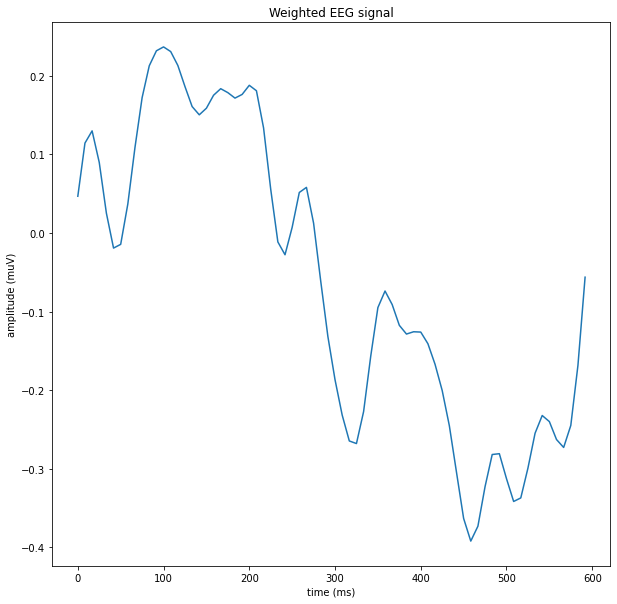

In [ ]:
plt.figure(figsize=(10, 10))
mean_output = -channel_weights @ output
t_axis = np.arange(len(mean_output)) / info['sfreq'] * 1000
plt.plot(t_axis, mean_output)
plt.ylabel('amplitude (muV)')
plt.xlabel('time (ms)')
plt.title('Weighted EEG signal')
plt.show()

In [ ]:
output[50].shape

(72,)

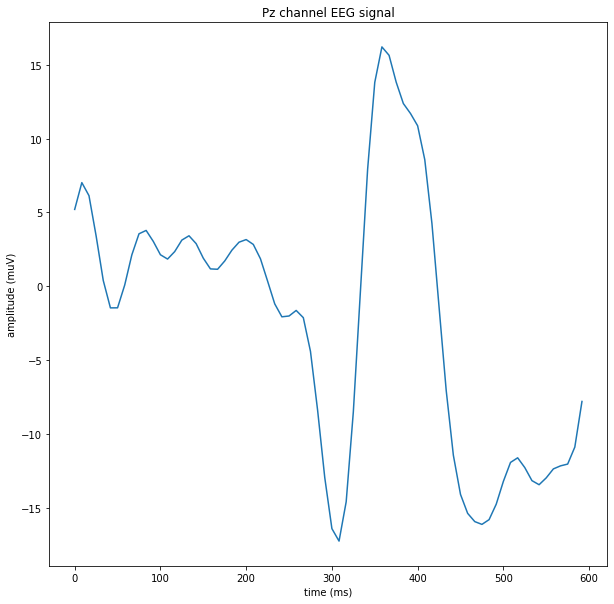

In [ ]:
plt.figure(figsize=(10, 10))
mean_output = output[50]
t_axis = np.arange(len(mean_output)) / info['sfreq'] * 1000
plt.plot(t_axis, mean_output)
plt.ylabel('amplitude (muV)')
plt.xlabel('time (ms)')
plt.title('Pz channel EEG signal')
plt.show()

In [ ]:
global encoding

def hook_fn(module, input, output):
    global encoding
    encoding = output

hook = model_CNN.hook.register_forward_hook(hook_fn)

In [ ]:
def get_encoding(model, dataloader, device):
    model.eval()
    batch_encoding = []
    classes = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        batch_encoding.append(encoding.cpu().detach())
        classes.append(labels)

    X = batch_encoding[0]
    y = classes[0]

    for labels, batch in zip(classes[1:], batch_encoding[1:]):
        X = torch.vstack((X, batch))
        y = torch.vstack((y, labels))

    return X.numpy(), y.numpy()

In [ ]:
X_A_test_enc, y_A_test_enc = get_encoding(model_CNN, data_loaders_CNN['val'], my_device)

In [ ]:
res = get_best_samples(model_CNN, data_loaders_CNN['val'], learning_params, top_n=8, device=my_device)

In [ ]:
y_A_test_enc.shape

(18000, 2)

In [ ]:
res[2]

tensor([0, 0, 1, 1])

In [ ]:
from sklearn.manifold import TSNE

tfidf_embed = TSNE(n_components=2).fit_transform(X_A_test_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


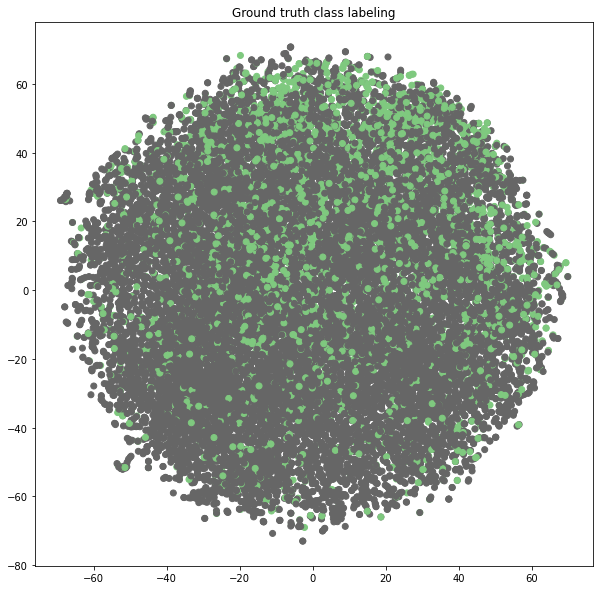

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x=tfidf_embed[:,0], y=tfidf_embed[:,1], c=y_A_test_enc[:,0], cmap="Accent")
plt.title('Ground truth class labeling')

#cb = plt.colorbar()
#loc = np.arange(0, max(y_A_test_enc), max(y_A_test_enc) / num_classes)
#cb.set_ticks(loc)
#cb.set_ticklabels(sorted(os.listdir(DATA_PATH)))
plt.show()

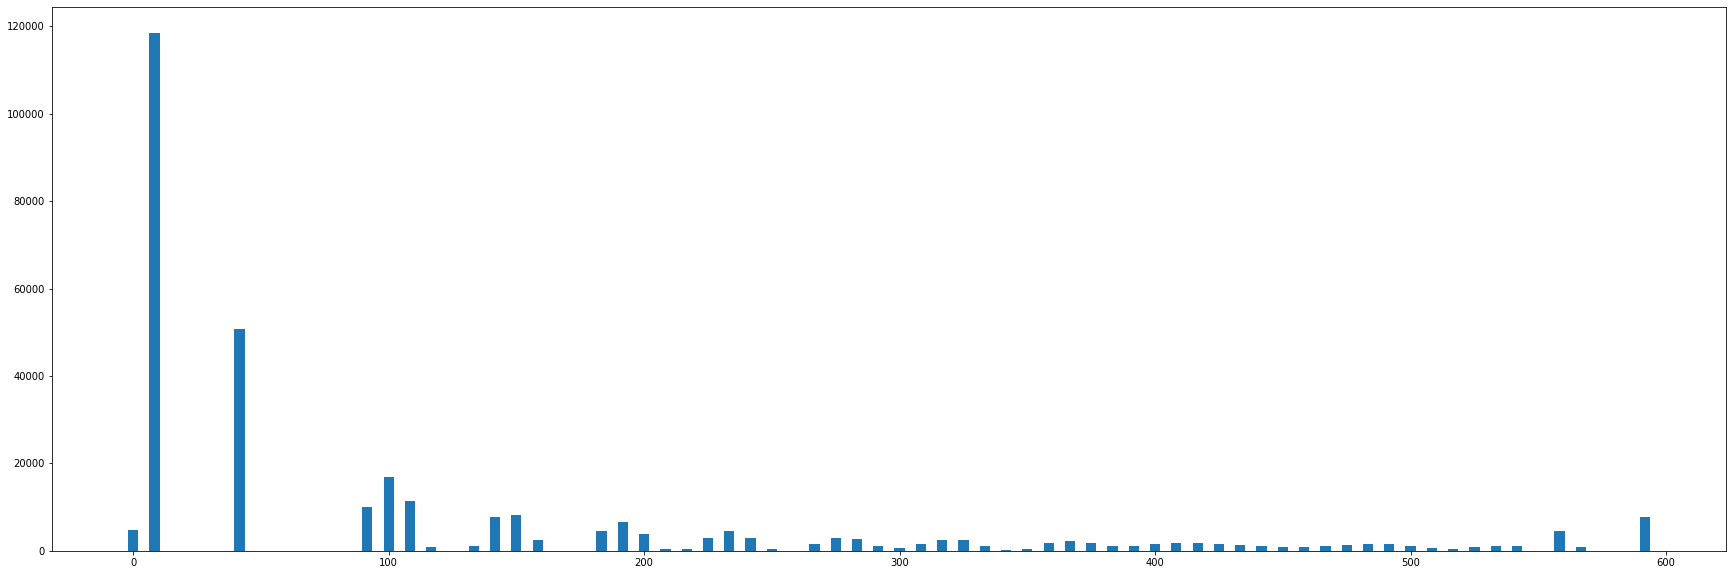

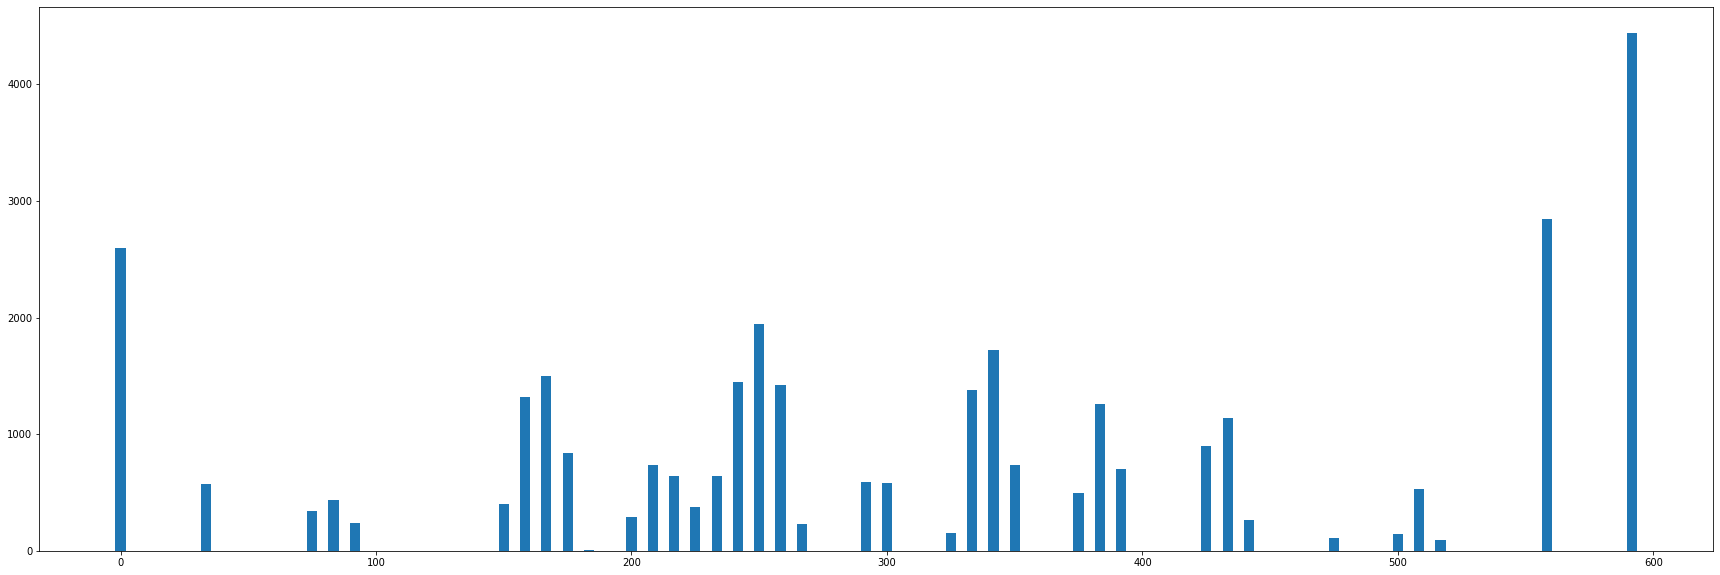

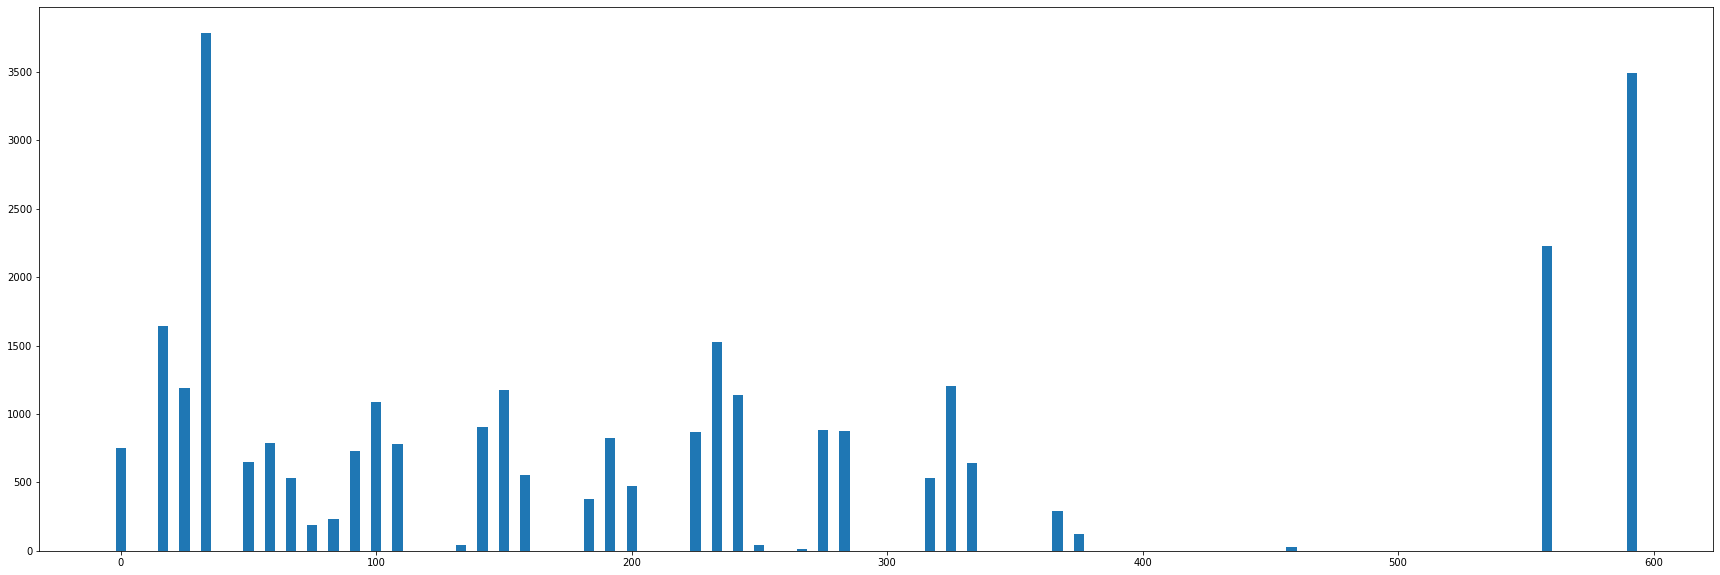

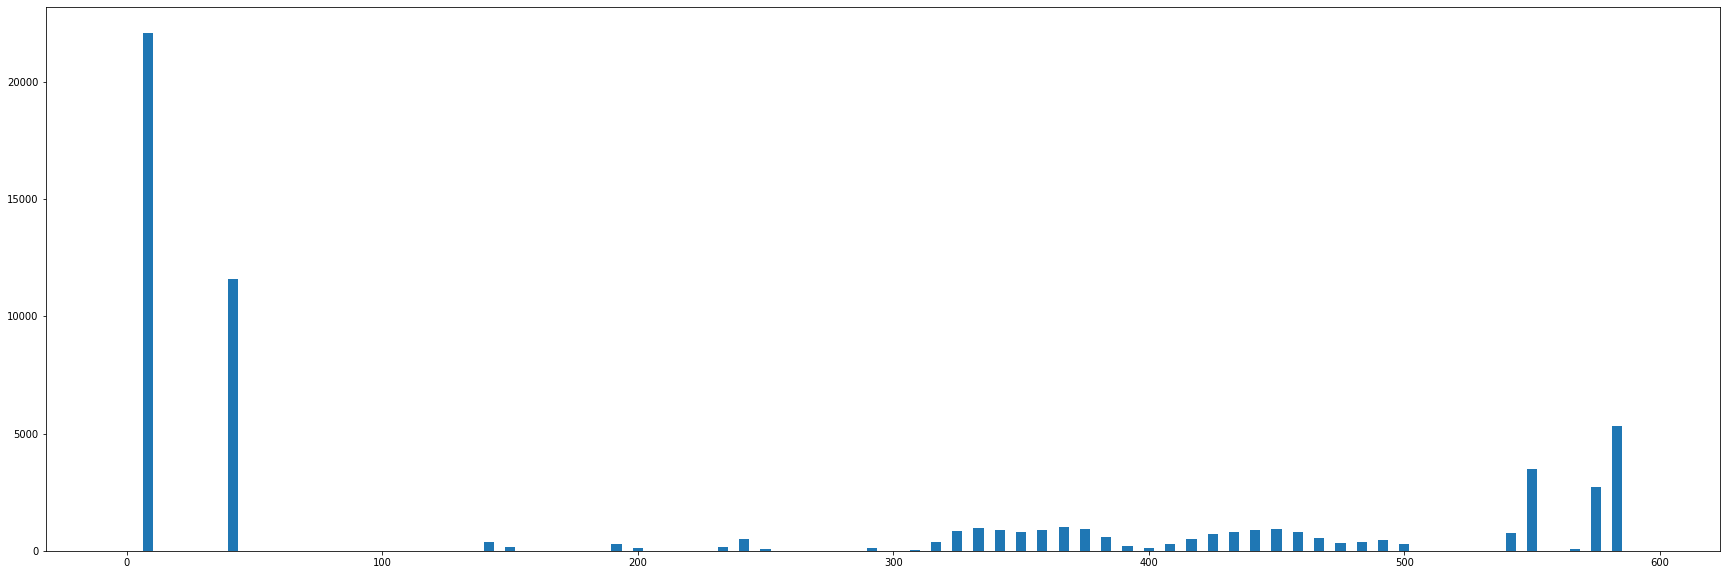

In [ ]:
for idx in res[0]:
    plt.figure(figsize=(30, 10))
    plt.bar(np.arange(72) / 120 * 1000, X_A_test_enc[idx], width=4)
    plt.show()

In [ ]:
channel_weights = np.array(model_CNN.linear_channel.weight.sum(dim=0).flatten().detach().cpu())

In [ ]:
channel_weights = np.array(model_CNN.linear_channel.weight.flatten().detach().cpu())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-66-0c266b42eae3>:3: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)


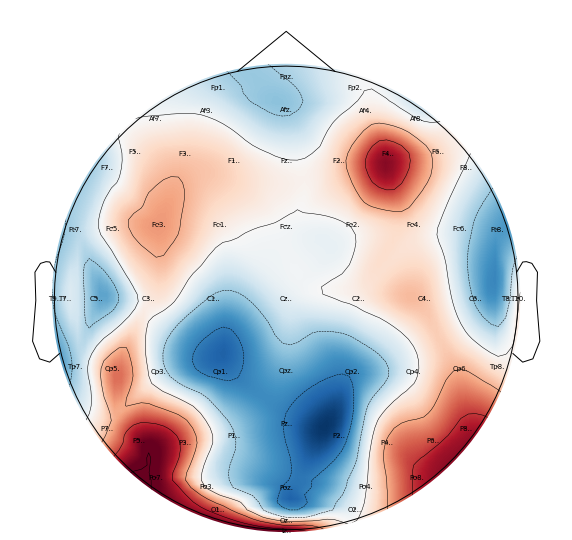

In [ ]:
channel_weights = np.array(model_CNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-35-0867926a22f9>:2: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)


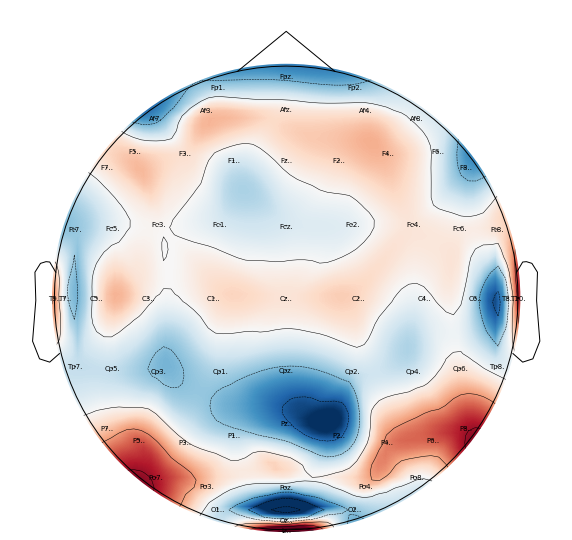

In [ ]:
mne.viz.plot_topomap(channel_weights, np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [ ]:
FZ , CZ , , P3, P4, , and OZ

In [ ]:
PO7, PO8, PZ

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-28-0867926a22f9>:2: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)


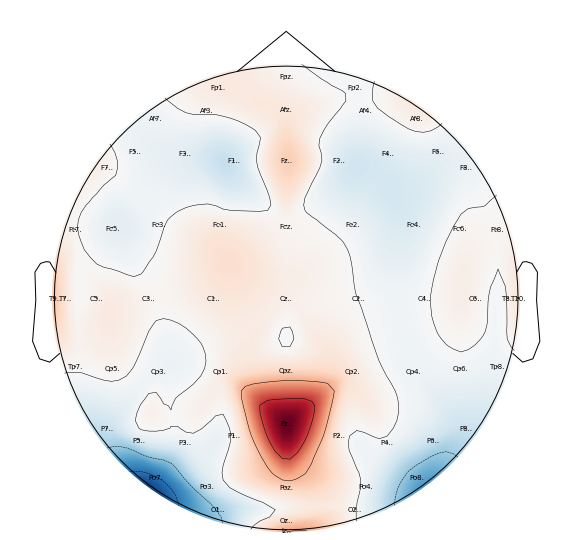

In [ ]:
mne.viz.plot_topomap(channel_weights, np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-63-95fc576034d4>:2: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)


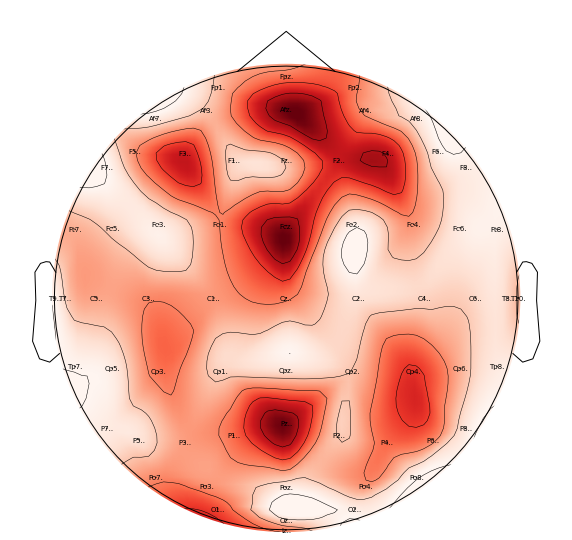

In [ ]:
mne.viz.plot_topomap(abs(channel_weights), np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-64-0867926a22f9>:2: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)


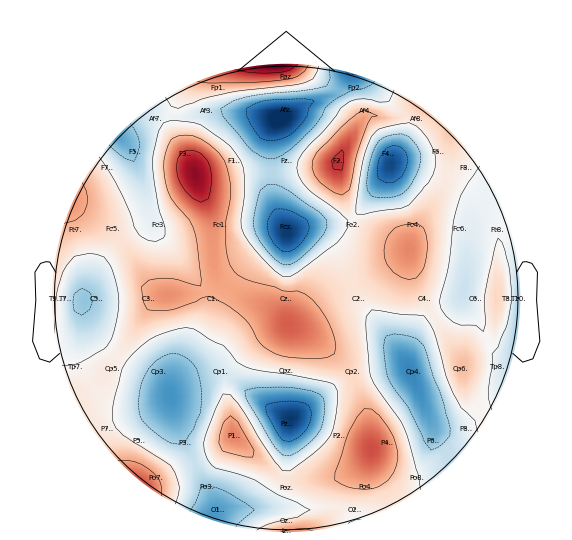

In [ ]:
mne.viz.plot_topomap(channel_weights, np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [ ]:
channel_weights = np.array(model_CNN.linear_output.weight.flatten().detach().cpu())

In [ ]:
np.array(eloc.ch_names)[channel_weights.argsort()[:5]]

array(['Pz..', 'Afz.', 'Fcz.', 'F4..', 'Fc3.'], dtype='<U4')

In [ ]:
np.array(eloc.ch_names)[channel_weights.argsort()]

array(['Po7.', 'Po8.', 'O1..', 'F1..', 'P8..', 'P7..', 'P6..', 'Po3.',
       'F2..', 'F4..', 'Fc4.', 'F3..', 'Fc5.', 'F6..', 'P5..', 'F8..',
       'F5..', 'Tp8.', 'Cp3.', 'Fc2.', 'Cp4.', 'Af7.', 'P3..', 'Po4.',
       'Cp6.', 'Af4.', 'P4..', 'Fc3.', 'C4..', 'Fp2.', 'C2..', 'T8..',
       'Ft7.', 'O2..', 'Tp7.', 'Fc6.', 'Ft8.', 'Af3.', 'C3..', 'P1..',
       'F7..', 'Fcz.', 'Cp5.', 'Fpz.', 'C6..', 'Af8.', 'Cz..', 'C5..',
       'Cp1.', 'T7..', 'P2..', 'Fp1.', 'Fc1.', 'T10.', 'Oz..', 'C1..',
       'Cp2.', 'Afz.', 'Cpz.', 'T9..', 'Fz..', 'Poz.', 'Iz..', 'Pz..'],
      dtype='<U4')

In [ ]:
channel_weights.argsort()

array([55, 59, 60, 32, 54, 46, 53, 56, 34, 35,  5, 31,  0, 36, 47, 37, 30,
       45, 15,  4, 19, 24, 48, 58, 20, 27, 52,  1, 12, 23, 11, 41, 38, 62,
       44,  6, 39, 25,  8, 49, 29,  3, 14, 22, 13, 28, 10,  7, 16, 40, 51,
       21,  2, 43, 61,  9, 18, 26, 17, 42, 33, 57, 63, 50])

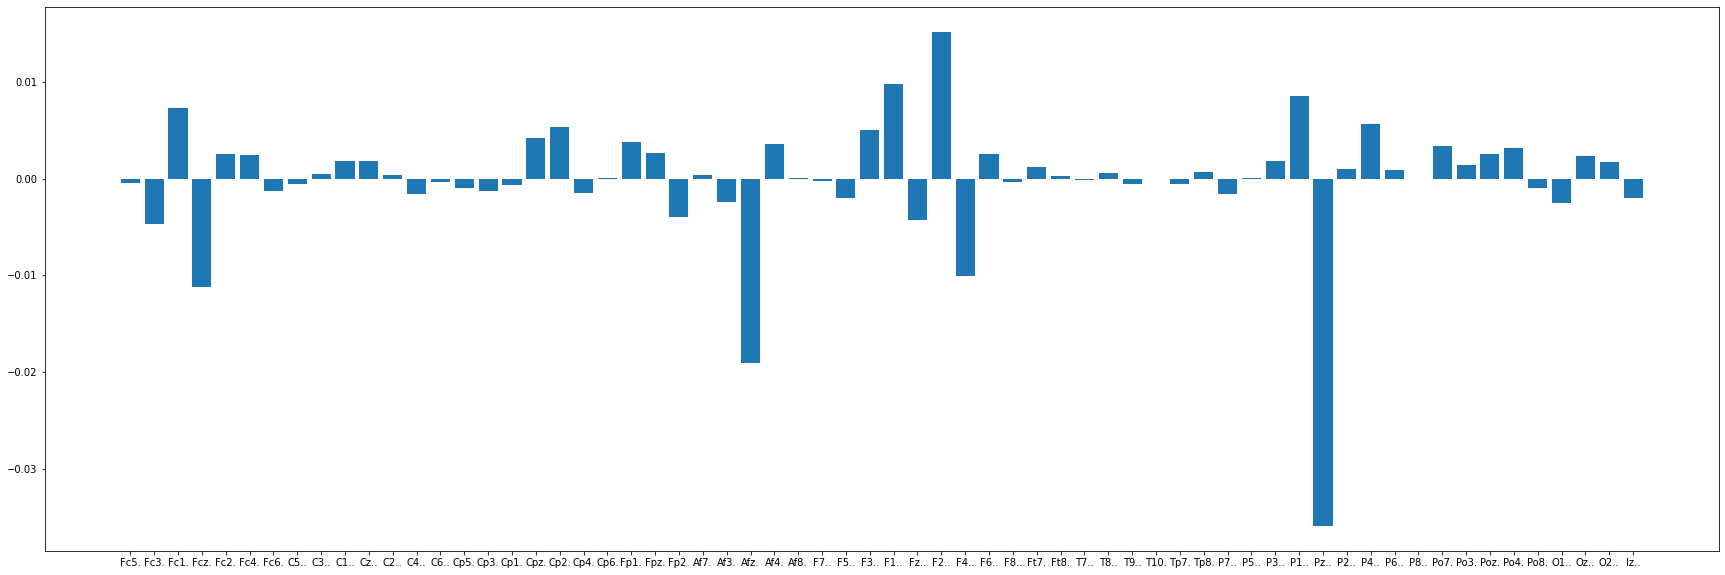

In [ ]:
plt.figure(figsize=(30, 10))
plt.bar(eloc.ch_names, channel_weights)
plt.show()

In [ ]:
model_CNN.linear_output.weight[1].detach().cpu()

tensor([ 2.1232e-04, -9.2217e-05,  1.5210e-04, -1.2045e-04,  1.1110e-04,
         5.2617e-05, -3.2897e-04,  1.2890e-03, -2.3935e-03,  3.0485e-03,
        -3.3942e-03,  2.6286e-03, -1.6276e-03,  7.5974e-04, -8.5418e-04,
         1.1576e-03, -1.5784e-03,  2.5213e-03, -3.3330e-03,  4.4806e-03,
        -4.8072e-03,  4.6699e-03, -3.9689e-03,  2.6388e-03, -1.5024e-03,
         1.6438e-03, -2.7367e-03,  4.5426e-03, -5.7131e-03,  7.4369e-03,
        -8.7850e-03,  8.6875e-03, -7.3334e-03,  5.2180e-03, -2.6575e-03,
         1.0556e-03,  1.0389e-03, -1.9259e-03,  2.3041e-03, -1.9318e-03,
         9.9531e-04,  4.9303e-04, -1.6316e-03,  2.4201e-03, -2.3035e-03,
         2.3922e-03, -2.6375e-03,  2.3253e-03, -1.7822e-03,  9.0571e-04,
        -3.7693e-04, -2.8882e-04,  1.0807e-03, -1.0463e-03,  5.7704e-06,
         8.9952e-04, -1.8362e-03,  2.6162e-03, -3.4109e-03,  3.8547e-03,
        -3.2723e-03,  2.3705e-03, -1.7805e-03,  9.3070e-04, -5.3512e-04,
        -7.0687e-06,  1.9593e-04, -2.6982e-04, -2.4

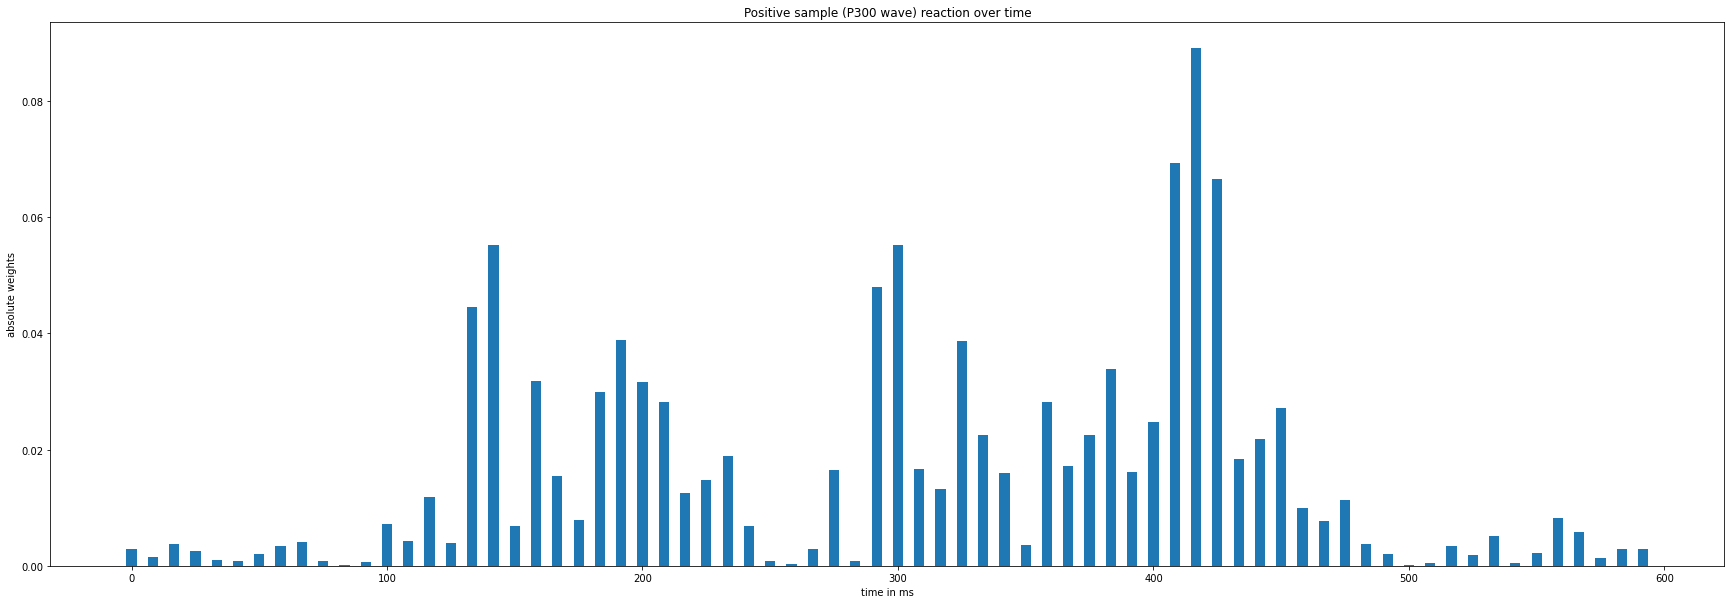

In [ ]:
plt.figure(figsize=(30, 10))
plt.bar(np.arange(72) / 120 * 1000, model_CNN.linear_output.weight[1].detach().cpu().abs(), width=4)
plt.title('Positive sample (P300 wave) reaction over time')
plt.xlabel('time in ms')
plt.ylabel('absolute weights')
plt.show()

In [ ]:
model_CNN.attn_weights.detach().cpu().sum(0)

tensor([-3.0379e-04, -1.0778e-05, -1.4432e-04,  1.1220e-04, -1.9273e-05,
        -4.4375e-05, -3.4462e-04,  6.2282e-04, -5.0083e-04,  3.6846e-04,
        -4.5824e-05,  4.2713e-04, -6.7493e-04,  5.6724e-04,  1.4988e-04,
        -4.7880e-04,  5.2229e-04, -7.3876e-04,  5.5118e-04, -6.9179e-04,
         5.9958e-04, -6.1627e-04,  2.4244e-04,  3.3952e-04, -1.0515e-03,
         1.1988e-03, -1.0795e-03,  9.5687e-04, -1.4145e-03,  1.1878e-03,
        -6.3479e-04,  4.8923e-04, -3.5385e-04,  7.5346e-05, -3.2410e-04,
        -1.1950e-04, -4.7786e-04,  1.8710e-04, -3.4984e-04,  2.3476e-04,
         2.4112e-04, -1.0638e-03,  1.5891e-03, -2.4003e-03,  2.5612e-03,
        -2.8358e-03,  2.9111e-03, -2.6886e-03,  1.8857e-03, -9.8312e-04,
         5.2796e-04, -3.1144e-04, -5.8975e-04,  5.0799e-04, -2.9247e-04,
         7.1927e-06, -5.0047e-04,  1.0714e-03, -1.7002e-03,  2.1188e-03,
        -3.1325e-03,  3.4556e-03, -3.3872e-03,  2.7728e-03, -1.7371e-03,
         6.3313e-04, -2.0858e-04,  1.2506e-04,  9.8

In [ ]:
model_CNN.attn_weights.detach().cpu().sum(0).size()

torch.Size([180])

ValueError: ignored

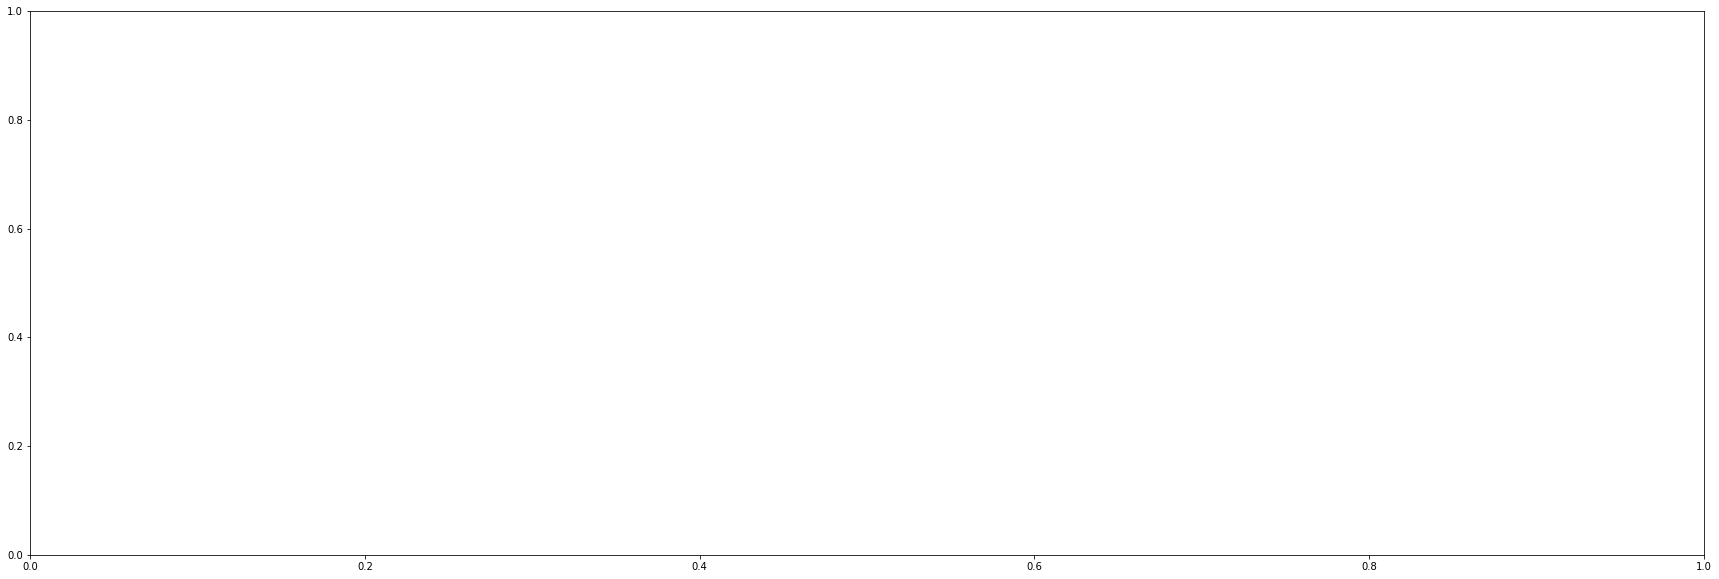

In [ ]:
plt.figure(figsize=(30, 10))
plt.bar(np.arange(72) / 120 * 1000, model_CNN.attn_weights.detach().cpu().sum(0), width=4)
plt.title('Negative sample (not P300 wave) reaction over time')
plt.xlabel('time in ms')
plt.ylabel('absolute weights')
plt.show()

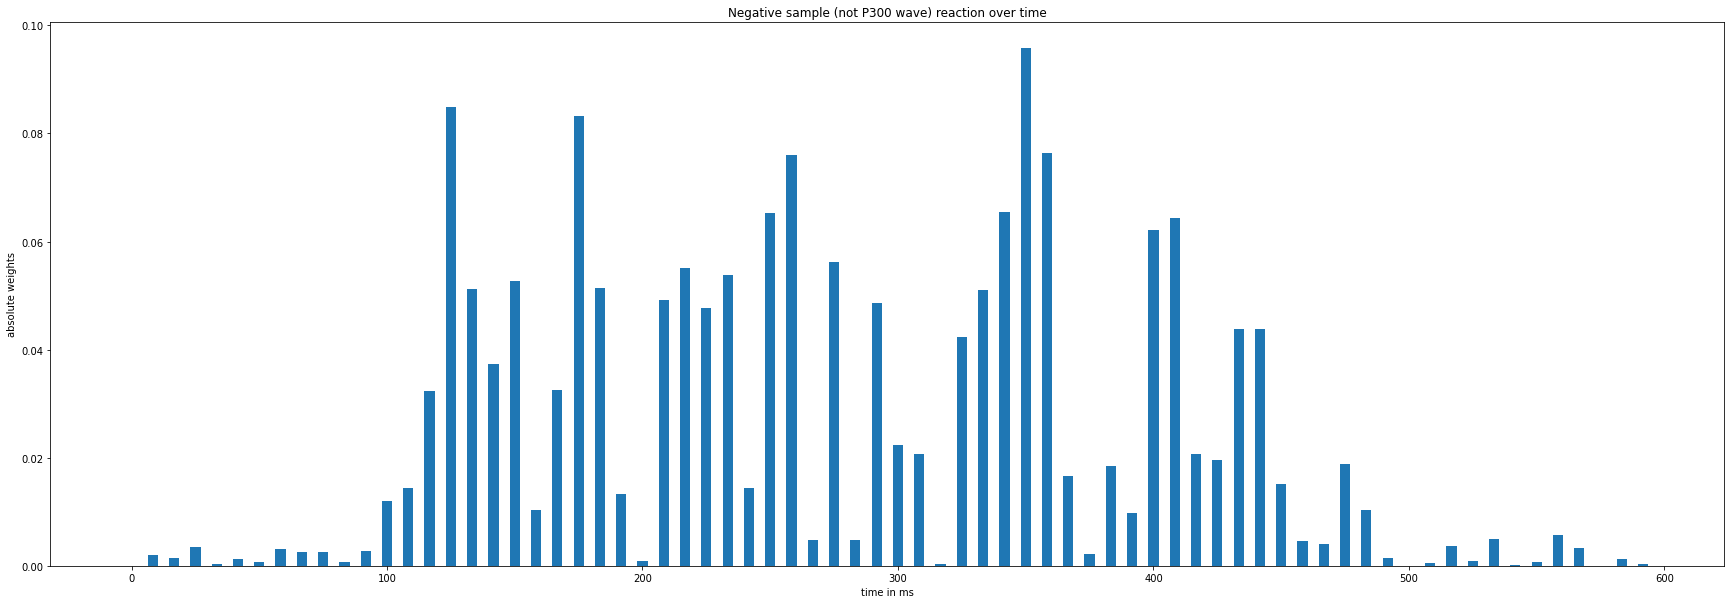

In [ ]:
plt.figure(figsize=(30, 10))
plt.bar(np.arange(72) / 120 * 1000, model_CNN.linear_output.weight[0].detach().cpu().abs(), width=4)
plt.title('Negative sample (not P300 wave) reaction over time')
plt.xlabel('time in ms')
plt.ylabel('absolute weights')
plt.show()

In [ ]:
criterion = nn.BCEWithLogitsLoss() #nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3)) weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-3,
    'weight_decay' : 0,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

model_CNN = CNN1(72, n_channels=64, num_layers=2, num_classes=2)

loss, acc, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, device=my_device)

cuda:0
Epoch 9/9
----------
train Loss: 0.4361 Acc: 0.8333 Ones: 1.0706
val Loss: 0.4700 Acc: 0.8287 Ones: 1.4100
Training complete in 1m 11s


In [ ]:
res = get_best_samples(model_CNN, data_loaders_CNN['val'], learning_params, top_n=4, device=my_device)

In [ ]:
best_sample = CNN_sample(*test_A_dataset[res[0][0]])

In [ ]:
best_sample = get_random_sample(test_A_dataset, learning_params, label=1)

In [ ]:
best_sample.x.shape

torch.Size([1, 64, 72])

In [ ]:
best_sample = generate_sample(model_CNN, best_sample, criterion, learning_params, num_steps = 1001, device=my_device)

----------
Step 0/1000
Loss: 2.8018
----------
Step 100/1000
Loss: 0.9892
----------
Step 200/1000
Loss: 0.3275
----------
Step 300/1000
Loss: 0.1557
----------
Step 400/1000
Loss: 0.0932
----------
Step 500/1000
Loss: 0.0633
----------
Step 600/1000
Loss: 0.0463
----------
Step 700/1000
Loss: 0.0357
----------
Step 800/1000
Loss: 0.0285
----------
Step 900/1000
Loss: 0.0234
----------
Step 1000/1000
Loss: 0.0196


<Figure size 1440x720 with 0 Axes>

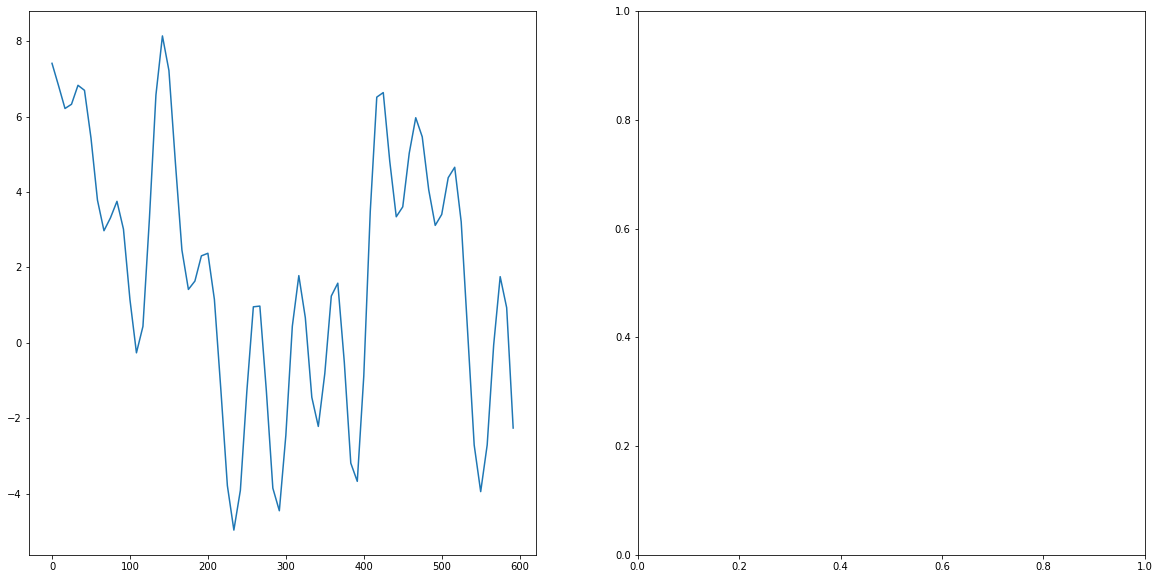

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


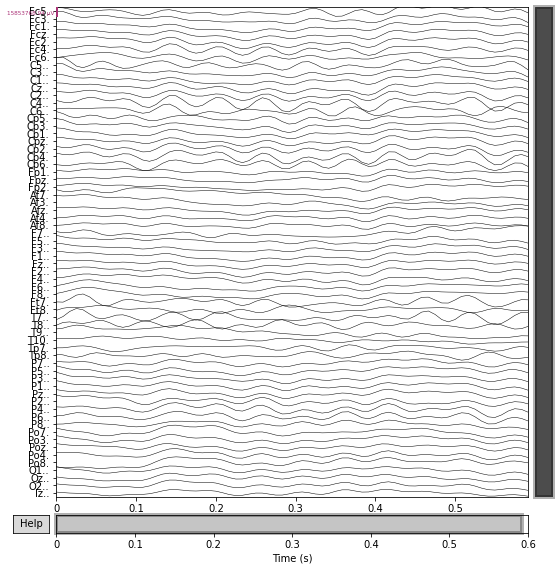

In [ ]:
plot_sample(A_test_ds, test_A_dataset[res[0][0]][0].unsqueeze(0), info)

In [ ]:
# сложить все каналы линейным слоем  
# потом можно применить пуллинг для выделения нужной области (высокоуровневые признаки)
# ??? 
# линейный слой на выходе

<Figure size 1440x720 with 0 Axes>

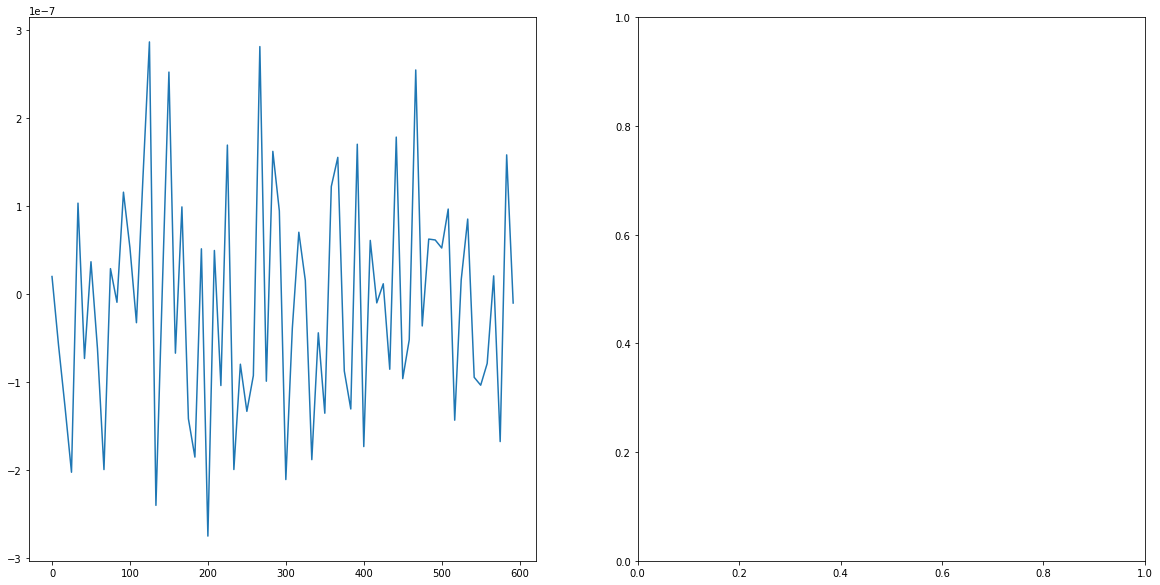

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


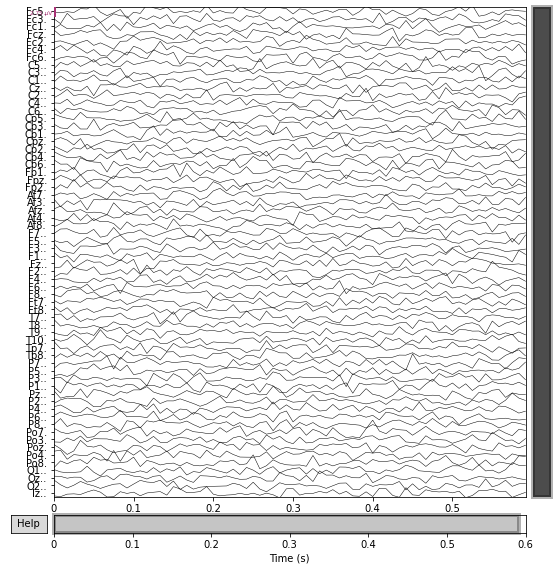

In [ ]:
plot_sample(A_test_ds, best_sample, info)

In [ ]:
def generate_sample_CNN(model, dataset, criterion, num_steps = 1001, label=1, device='cpu'):    
    model.eval()
    model.requires_grad_(False)
    input_size = dataset[0][0].unsqueeze(0).size()
    x = torch.randn(input_size, requires_grad=True, device=device)
    y = (torch.arange(0, num_classes) == label).float().unsqueeze(0)
    y = y.to(device)
    optimizer = optim.Adam([x], lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    num_steps = 1001

    for step in range(num_steps):
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % 100 == 0:
            scheduler.step()
            print('-' * 10)
            print('Step {}/{}'.format(step, num_steps - 1))
            print('Loss: {:.4f}'.format(loss.item()))

    return x.detach().cpu()[0]

In [ ]:
model_CNN.eval()
model_CNN.requires_grad_(False)
x = torch.randn((1, 64, 72), requires_grad=True, device=my_device)
y = torch.tensor([[0., 1.]], device=my_device)
optimizer = optim.Adam([x], lr=lr)
#scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
num_steps = 1001

for step in range(num_steps):
    loss = criterion(model_CNN(x), y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if step % 100 == 0:
      
      print('-' * 10)
      print('Step {}/{}'.format(step, num_steps - 1))
      print('Loss: {:.4f}'.format(loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


----------
Step 0/1000
Loss: 10.9001
----------
Step 100/1000
Loss: 0.0164
----------
Step 200/1000
Loss: 0.0079
----------
Step 300/1000
Loss: 0.0048
----------
Step 400/1000
Loss: 0.0032
----------
Step 500/1000
Loss: 0.0023
----------
Step 600/1000
Loss: 0.0018
----------
Step 700/1000
Loss: 0.0014
----------
Step 800/1000
Loss: 0.0011
----------
Step 900/1000
Loss: 0.0009
----------
Step 1000/1000
Loss: 0.0008


In [ ]:
temp = generate_sample_CNN(model_CNN, test_A_dataset, criterion, device=my_device)

----------
Step 0/1000
Loss: 8.3270
----------
Step 100/1000
Loss: 0.0283
----------
Step 200/1000
Loss: 0.0116
----------
Step 300/1000
Loss: 0.0066
----------
Step 400/1000
Loss: 0.0043
----------
Step 500/1000
Loss: 0.0031
----------
Step 600/1000
Loss: 0.0023
----------
Step 700/1000
Loss: 0.0018
----------
Step 800/1000
Loss: 0.0015
----------
Step 900/1000
Loss: 0.0012
----------
Step 1000/1000
Loss: 0.0010


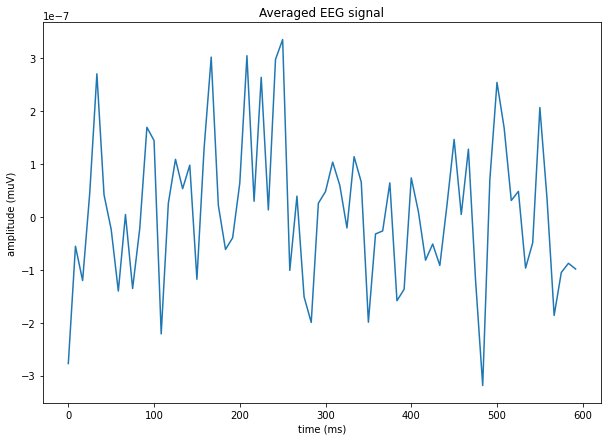

In [ ]:
plot_sample(A_test_ds, temp)

In [ ]:
def get_best_samples(model, dataset, criterion, top_n=4, label=1, device='cpu'):
    dataloader = DataLoader(dataset, batch_size=1)
    model.eval()
    single_loss = []
    single_labels = []
    preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        single_labels.append(labels.int().tolist()[0])
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        _, true_y = torch.max(labels.data, 1)

        preds.append(loss.item())
        
        loss = criterion(outputs, labels)
        single_loss.append(loss.item())

    single_loss = np.array(single_loss).argsort()#[:top_n]
    if label:
        label_mask = np.array(single_labels)[:,label]
        single_loss = np.ma.masked_where(label_mask, single_loss)#single_loss[label_mask]
        single_loss = np.ma.compressed(single_loss)

    return single_labels, np.array(preds)#, dataset[single_loss[:top_n]]

In [ ]:
labels, preds = get_best_samples(model_CNN, test_A_dataset, criterion, device=my_device)

NameError: ignored

In [ ]:
t = get_best_samples(model_CNN, test_A_dataset, criterion, device=my_device)

In [ ]:
def plot_sample(raw_dataset, signal_sample):
    output = raw_dataset.unscale(np.expand_dims(signal_sample.numpy(), 0))[0].mean(axis=0)
    t_axis = np.arange(len(output)) / 120 * 1000
    plt.figure(figsize=(10 ,7))
    plt.plot(t_axis, output)
    plt.ylabel('amplitude (muV)')
    plt.xlabel('time (ms)')
    plt.title('Averaged EEG signal')
    plt.show()

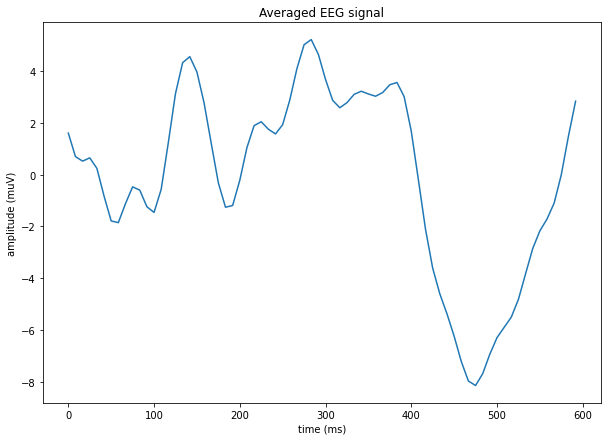

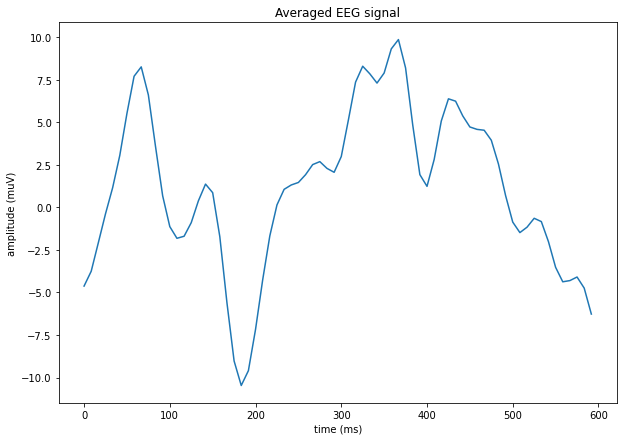

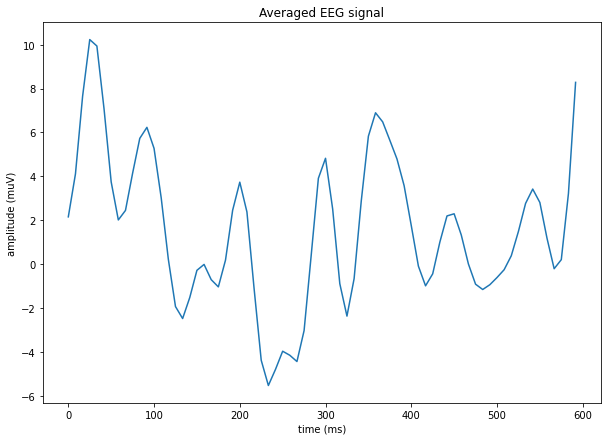

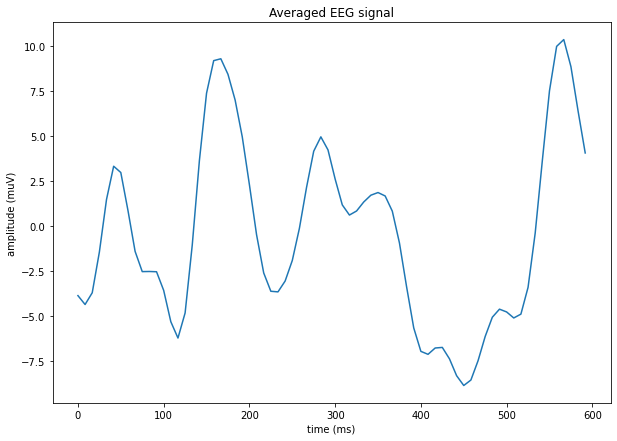

In [ ]:
for i in range(4):
    plot_sample(A_test_ds, t[0][i])

In [ ]:

torch.randn(Del_A_train_data[0].x.size()).size()

torch.Size([64, 72])

In [ ]:
num_classes = 2

In [ ]:
def generate_sample_GNN(model, dataset, criterion, num_steps = 1001, label=1, device='cpu'):    
    model.eval()
    model.requires_grad_(False)
    temp_loader = GraphLoader(dataset, batch_size=1)
    temp = next(iter(temp_loader))
    temp.y = (torch.arange(0, num_classes) == label).float().unsqueeze(0)
    input_size = dataset[0].x.size()
    temp.x = torch.randn(input_size)
    temp = temp.to(device)
    temp.x = temp.x.requires_grad_()
    optimizer = optim.Adam([temp.x], lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    num_steps = 1001

    for step in range(num_steps):
        loss = criterion(model(temp), temp.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % 100 == 0:
            scheduler.step()
            print('-' * 10)
            print('Step {}/{}'.format(step, num_steps - 1))
            print('Loss: {:.4f}'.format(loss.item()))

    return temp.x.detach().cpu()

In [ ]:
temp = generate_sample_GNN(model_GNN, Del_A_train_data, criterion, device=my_device)

----------
Step 0/1000
Loss: 1.7815
----------
Step 100/1000
Loss: 1.7815
----------
Step 200/1000
Loss: 1.7815
----------
Step 300/1000
Loss: 1.7815
----------
Step 400/1000
Loss: 1.7815
----------
Step 500/1000
Loss: 1.7815
----------
Step 600/1000
Loss: 1.7815
----------
Step 700/1000
Loss: 1.7815
----------
Step 800/1000
Loss: 1.7815
----------
Step 900/1000
Loss: 1.7815
----------
Step 1000/1000
Loss: 1.7815


In [ ]:
model_GNN(temp)

tensor([[ 1.5981, -1.5961]], device='cuda:0', grad_fn=<AddmmBackward0>)

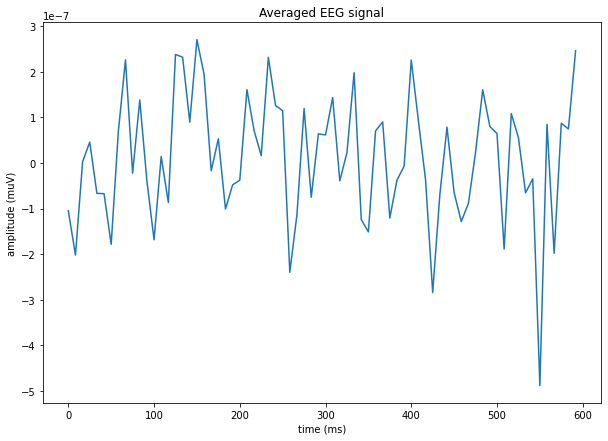

In [ ]:
plot_sample(A_test_ds, temp.x.detach().cpu())

In [ ]:
# переделать через maximum response

def get_best_samples_GNN(model, dataset, criterion, top_n=4, label=1, device='cpu'):
    dataloader = GraphLoader(dataset, batch_size=1)
    model.eval()
    single_loss = []
    single_labels = []

    for data in dataloader:
        inputs = data.to(device)
        labels = data.y
        single_labels.append(labels.int().tolist()[0])
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        single_loss.append(loss.item())

    single_loss = np.array(single_loss).argsort()#[:top_n]
    if label:
        label_mask = np.array(single_labels)[:,label]
        single_loss = np.ma.masked_where(label_mask, single_loss)#single_loss[label_mask]
        single_loss = np.ma.compressed(single_loss)

    return dataset[single_loss][:top_n]

In [ ]:
t = get_best_samples_GNN(model_GNN, Del_A_train_data, criterion, device=my_device)

In [ ]:
model_GNN(t[0].to(my_device))

tensor([[ 706.2264, -485.5944]], device='cuda:0')

tensor([[1., 0.]])


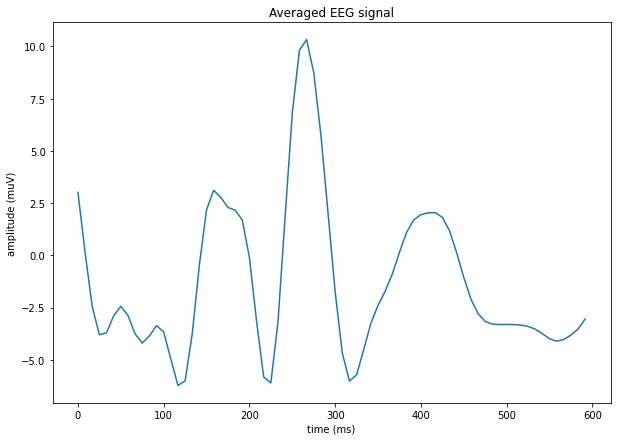

tensor([[1., 0.]])


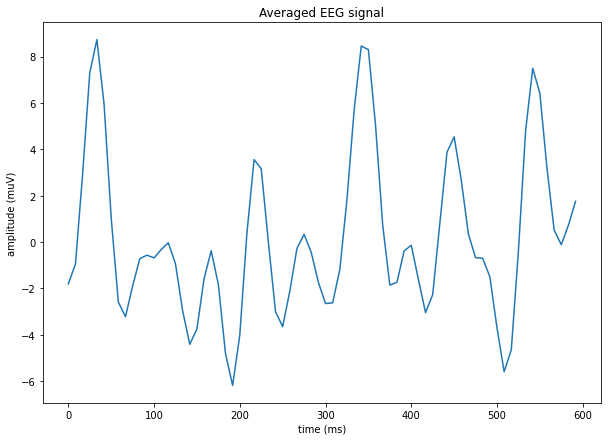

tensor([[1., 0.]])


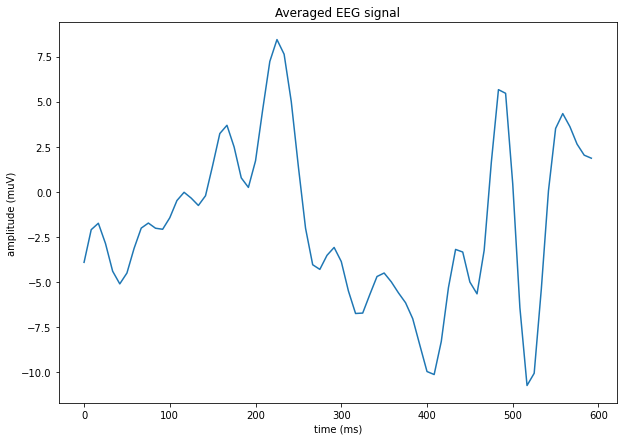

tensor([[1., 0.]])


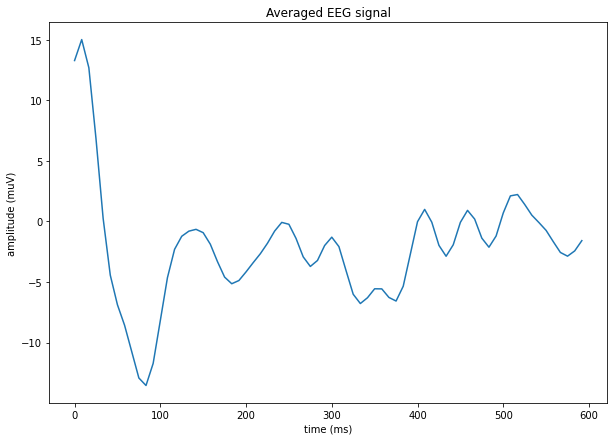

In [ ]:
for i in range(4):
    print(t[i].y.detach().cpu())
    plot_sample(A_test_ds, t[i].x.detach().cpu())